In [4]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Autoencoder

https://github.com/aymericdamien/TensorFlow-Examples/blob/master/examples/3_NeuralNetworks/autoencoder.py


In [5]:
import os
#print(os.environ["CUDA_HOME"])
#os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"

os.environ['CUDA_HOME'] = '/usr/local/cuda-9.2'
os.environ["CUDA_VISIBLE_DEVICES"]='0'

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10798287992016293380
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 14961407943709102024
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 6051462451402188352
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10743696589
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4701128856365467022
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]


In [6]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random
import sys
import pandas as pd

In [7]:
DATA_DIRECTORY = '/home/reflex/refleX/metadata/labeled/original512/'
CSV_DIRECTORY = '/home/reflex/refleX/metadata/csv/'
TRAIN_CSV = f'{CSV_DIRECTORY}train.csv'
VALIDATE_CSV = f'{CSV_DIRECTORY}validate.csv'
TEST_CSV = f'{CSV_DIRECTORY}test.csv'
RESULT_DIRECTORY = '/home/reflex/refleX/results/autoencoder/'

In [8]:
RESOLUTION = 256
CLASSNAME = 'ice_ring'

In [9]:
def load_data(directory, csv_path, classname, image_size=512): # TODO include image_size
    from skimage.measure import block_reduce
    
    df = pd.read_csv(csv_path, index_col='image')
    num_images = df.shape[0]
    
    images = np.ndarray(shape=(num_images, image_size*image_size), dtype=np.float32)
    # classes = df.values.astype(bool) # to consider all classes at once
    classes = df.loc[:, classname].values.astype(bool) # to consider all classes at once
    
    for i, imname in enumerate(df.index.values):
        temp = plt.imread(directory+imname+'.png')
        images[i] = block_reduce(temp, (2,2), np.max).flatten()

    assert images.shape[0] == classes.shape[0]    
    
    return {
        'images': images,
        'classes': classes
    }

In [10]:
training_data = load_data(DATA_DIRECTORY, TRAIN_CSV, CLASSNAME, RESOLUTION)
validation_data = load_data(DATA_DIRECTORY, VALIDATE_CSV, CLASSNAME, RESOLUTION)
testing_data = load_data(DATA_DIRECTORY, TEST_CSV, CLASSNAME, RESOLUTION)
assert training_data['images'].shape[-1] == validation_data['images'].shape[-1] == testing_data['images'].shape[-1]

In [11]:
learning_rate = 0.001 
training_epochs = 10000
batch_size = 32
display_step = 100
examples_to_show = 10

In [12]:
n_hidden_1 = 32#64
n_hidden_2 = 16#32
n_input = training_data['images'].shape[-1]

In [13]:
# assumes square images
def plot(original_images, output_images, examples_to_show=10):
    assert original_images.shape[0] == output_images.shape[0]
    examples_to_show = min(examples_to_show, original_images.shape[0])
    square_imsize = int(np.sqrt(original_images[-1].shape[-1]))
    f, a = plt.subplots(2, examples_to_show, figsize=(2*examples_to_show, 4))
    for i in range(examples_to_show):
        a[0][i].imshow(np.reshape(original_images[i], (square_imsize, square_imsize)))
        a[1][i].imshow(np.reshape(output_images[i], (square_imsize, square_imsize)))
    f.show()
    #plt.show()

Epoch: 0001 loss= 1.513493180
Epoch: 0101 loss= 0.423669189
Epoch: 0201 loss= 0.333501637
Epoch: 0301 loss= 0.285871029
Epoch: 0401 loss= 0.257878184
Epoch: 0501 loss= 0.237293810
Epoch: 0601 loss= 0.220386848
Epoch: 0701 loss= 0.207695901
Epoch: 0801 loss= 0.199622780
Epoch: 0901 loss= 0.190377608
Epoch: 1001 loss= 0.182715118
Epoch: 1101 loss= 0.177910626
Epoch: 1201 loss= 0.172290653
Epoch: 1301 loss= 0.166931286
Epoch: 1401 loss= 0.158618480
Epoch: 1501 loss= 0.155874044
Epoch: 1601 loss= 0.150859982
Epoch: 1701 loss= 0.146349400
Epoch: 1801 loss= 0.142678574
Epoch: 1901 loss= 0.140770882
Epoch: 2001 loss= 0.139676958
Epoch: 2101 loss= 0.133820876
Epoch: 2201 loss= 0.134799570
Epoch: 2301 loss= 0.132800832
Epoch: 2401 loss= 0.128114715
Epoch: 2501 loss= 0.127897993
Epoch: 2601 loss= 0.123044059
Epoch: 2701 loss= 0.121143766
Epoch: 2801 loss= 0.120471045
Epoch: 2901 loss= 0.117557339
Epoch: 3001 loss= 0.117599793
Epoch: 3101 loss= 0.116316363
Epoch: 3201 loss= 0.114821061
Epoch: 330

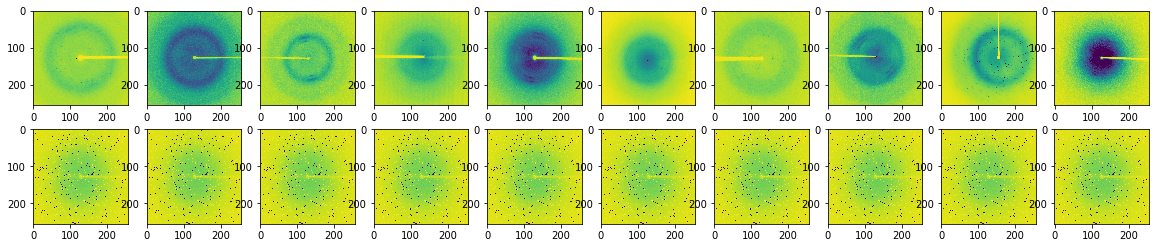

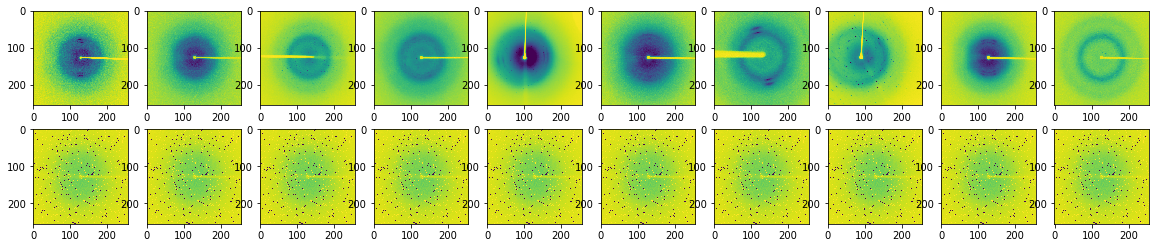

In [14]:
%%time

config=tf.ConfigProto(log_device_placement=True)

tfDevice = '/gpu:0'
with tf.device(tfDevice):

    tf.reset_default_graph()

    # tf Graph input (only pictures)
    X = tf.placeholder("float", [None, n_input])

    weights = {
        'encoder_h1': tf.Variable(tf.random_normal([n_input, n_hidden_1])),
        'encoder_h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
        'decoder_h1': tf.Variable(tf.random_normal([n_hidden_2, n_hidden_1])),
        'decoder_h2': tf.Variable(tf.random_normal([n_hidden_1, n_input])),
    }
    biases = {
        'encoder_b1': tf.Variable(tf.random_normal([n_hidden_1])),
        'encoder_b2': tf.Variable(tf.random_normal([n_hidden_2])),
        'decoder_b1': tf.Variable(tf.random_normal([n_hidden_1])),
        'decoder_b2': tf.Variable(tf.random_normal([n_input])),
    }
    
    saver = tf.train.Saver()

    def encoder(x):
        layer_1 = tf.nn.tanh(tf.add(tf.matmul(x, weights['encoder_h1']),
                                       biases['encoder_b1']))
        layer_2 = tf.nn.tanh(tf.add(tf.matmul(layer_1, weights['encoder_h2']),
                                       biases['encoder_b2']))
        return layer_2


    def decoder(x):
        layer_1 = tf.nn.tanh(tf.add(tf.matmul(x, weights['decoder_h1']),
                                       biases['decoder_b1']))
        layer_2 = tf.nn.tanh(tf.add(tf.matmul(layer_1, weights['decoder_h2']),
                                       biases['decoder_b2']))
        return layer_2

    encoder_op = encoder(X)
    decoder_op = decoder(encoder_op)

    y_pred = decoder_op
    y_true = X

    loss = tf.reduce_mean(tf.pow(y_true - y_pred, 2))
    optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize(loss)

    init = tf.global_variables_initializer()

    with tf.Session(config=config) as sess:
        sess.run(init)
        
        # Train
        total_batch = int(training_data['images'].shape[0]/batch_size)

        for epoch in range(training_epochs):
            # Loop over all batches
            ran = list(range(total_batch))
            random.shuffle(ran)
            for i in ran:
                batch_xs = training_data['images'][(batch_size*i):(batch_size*(i+1))]
                _, c = sess.run([optimizer, loss], feed_dict={X: batch_xs})

            if epoch % display_step == 0:
                print("Epoch:", '%04d' % (epoch+1), "loss=", "{:.9f}".format(c))
                sys.stdout.flush()

        # Test on training data # TODO Remove
        encode_decode = sess.run(y_pred, feed_dict={X: training_data['images'][:10]})
        plot(training_data['images'][:10], encode_decode, examples_to_show)        
        
        # Test
        encode_decode = sess.run(y_pred, feed_dict={X: testing_data['images']})
        plot(testing_data['images'], encode_decode, examples_to_show)
        
        print(f'Saved model in {saver.save(sess, "./TEMP/temp32_16")}') # temp=64_32